## compare multiple umap spaces

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(argparse)))

In [2]:
# set paths 
CP_umap_file_path <- file.path("../../data/umap/",paste0("CP_umap_transformed.parquet"))
scDINO_umap_file_path <- file.path("../../data/umap/",paste0("scDINO_umap_transformed.parquet"))
combined_umap_file_path <- file.path("../../data/umap/",paste0("combined_umap_transformed.parquet"))

figures_path <- file.path(paste0("../figures/all_compared/"))
if (!dir.exists(figures_path)) {
  dir.create(figures_path)
}

CP_umap_df <- arrow::read_parquet(CP_umap_file_path)
scDINO_umap_df <- arrow::read_parquet(scDINO_umap_file_path)
combined_umap_df <- arrow::read_parquet(combined_umap_file_path)
shared_columns <- intersect(colnames(CP_umap_df), intersect(colnames(scDINO_umap_df), colnames(combined_umap_df)))
CP_umap_df <- CP_umap_df[,shared_columns]
scDINO_umap_df <- scDINO_umap_df[,shared_columns]
combined_umap_df <- combined_umap_df[,shared_columns]
# rbind the dataframes
# remove the first two or three zeros in Metadata time 

scDINO_umap_df$Metadata_Time <- gsub("^000", "0", scDINO_umap_df$Metadata_Time)
scDINO_umap_df$Metadata_Time <- gsub("^00", "", scDINO_umap_df$Metadata_Time)
scDINO_umap_df$Metadata_Time <- gsub("^0", "", scDINO_umap_df$Metadata_Time)
scDINO_umap_df$Metadata_Time <- as.numeric(scDINO_umap_df$Metadata_Time) - 1
combined_umap_df$Metadata_Time <- as.integer(combined_umap_df$Metadata_Time)
CP_umap_df$Metadata_Time <- as.integer(CP_umap_df$Metadata_Time)

CP_umap_df$data_type <- "CP"
scDINO_umap_df$data_type <- "scDINO"
combined_umap_df$data_type <- "combined"
umap_df <- rbind(CP_umap_df, scDINO_umap_df, combined_umap_df)
head(umap_df)

Metadata_Well,Metadata_compound,Metadata_dose,Metadata_control,Metadata_ImageNumber,Metadata_FOV,Metadata_Time,Metadata_Nuclei_Number_Object_Number,UMAP0,UMAP1,data_type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
C-09,Staurosporine,39.06,positive,1,0002,0,2,-2.7109926,-3.6711025,CP
C-09,Staurosporine,39.06,positive,1,0002,0,6,-4.7052236,-2.3512323,CP
C-09,Staurosporine,39.06,positive,1,0002,0,7,0.1897865,-3.5664909,CP
C-09,Staurosporine,39.06,positive,1,0002,0,9,-3.9746747,-2.2033219,CP
C-09,Staurosporine,39.06,positive,1,0002,0,10,-2.0203211,-0.6382954,CP
C-09,Staurosporine,39.06,positive,1,0002,0,11,-1.6500847,-2.0165570,CP


In [3]:
# replace 0.0 with 0 if needed
umap_df$Metadata_dose <- as.character(umap_df$Metadata_dose)
umap_df$Metadata_dose[umap_df$Metadata_dose == "0.0"] <- "0"

In [4]:
unique(umap_df$data_type)
umap_df$data_type <- factor(umap_df$data_type, levels = c("CP", "scDINO", "combined"))
# color pallete for profile
data_type_colors <- c(
    "CP" = "#1f77b4", #1f77b4
    "scDINO" = "#ff7f0e", #ff7f0e
    "combined" = "#2ca02c") #2ca02c

[1] "CP"       "scDINO"   "combined"

In [5]:
# add nM to the dose column
umap_df$Metadata_dose <- paste0(umap_df$Metadata_dose, " nM")
# make the dose a factor with levels
umap_df$Metadata_dose <- factor(umap_df$Metadata_dose, levels = c(
    "0 nM",
    "0.61 nM",
    "1.22 nM",
    "2.44 nM",
    "4.88 nM",
    "9.77 nM",
    "19.53 nM",
    "39.06 nM",
    "78.13 nM",
    "156.25 nM"
    )
    )



# make time a factor with levels
# replace the "T000" with ""
umap_df$Metadata_Time <- gsub("T00", "", umap_df$Metadata_Time)
# make time an integer
umap_df$Metadata_Time <- as.integer(umap_df$Metadata_Time)
# change the Metadata Time columnd to minutes
umap_df$Metadata_Time <- ((umap_df$Metadata_Time)) * 30
# add "min" to the time column
umap_df$Metadata_Time <- paste0(umap_df$Metadata_Time, " min")
# make the metadata time column a factor with levels
umap_df$Metadata_Time <- factor(umap_df$Metadata_Time, levels = c(
    "0 min",
    "30 min",
    "60 min",
    "90 min",
    "120 min",
    "150 min",
    "180 min",
    "210 min",
    "240 min",
    "270 min",
    "300 min",
    "330 min",
    "360 min"
))


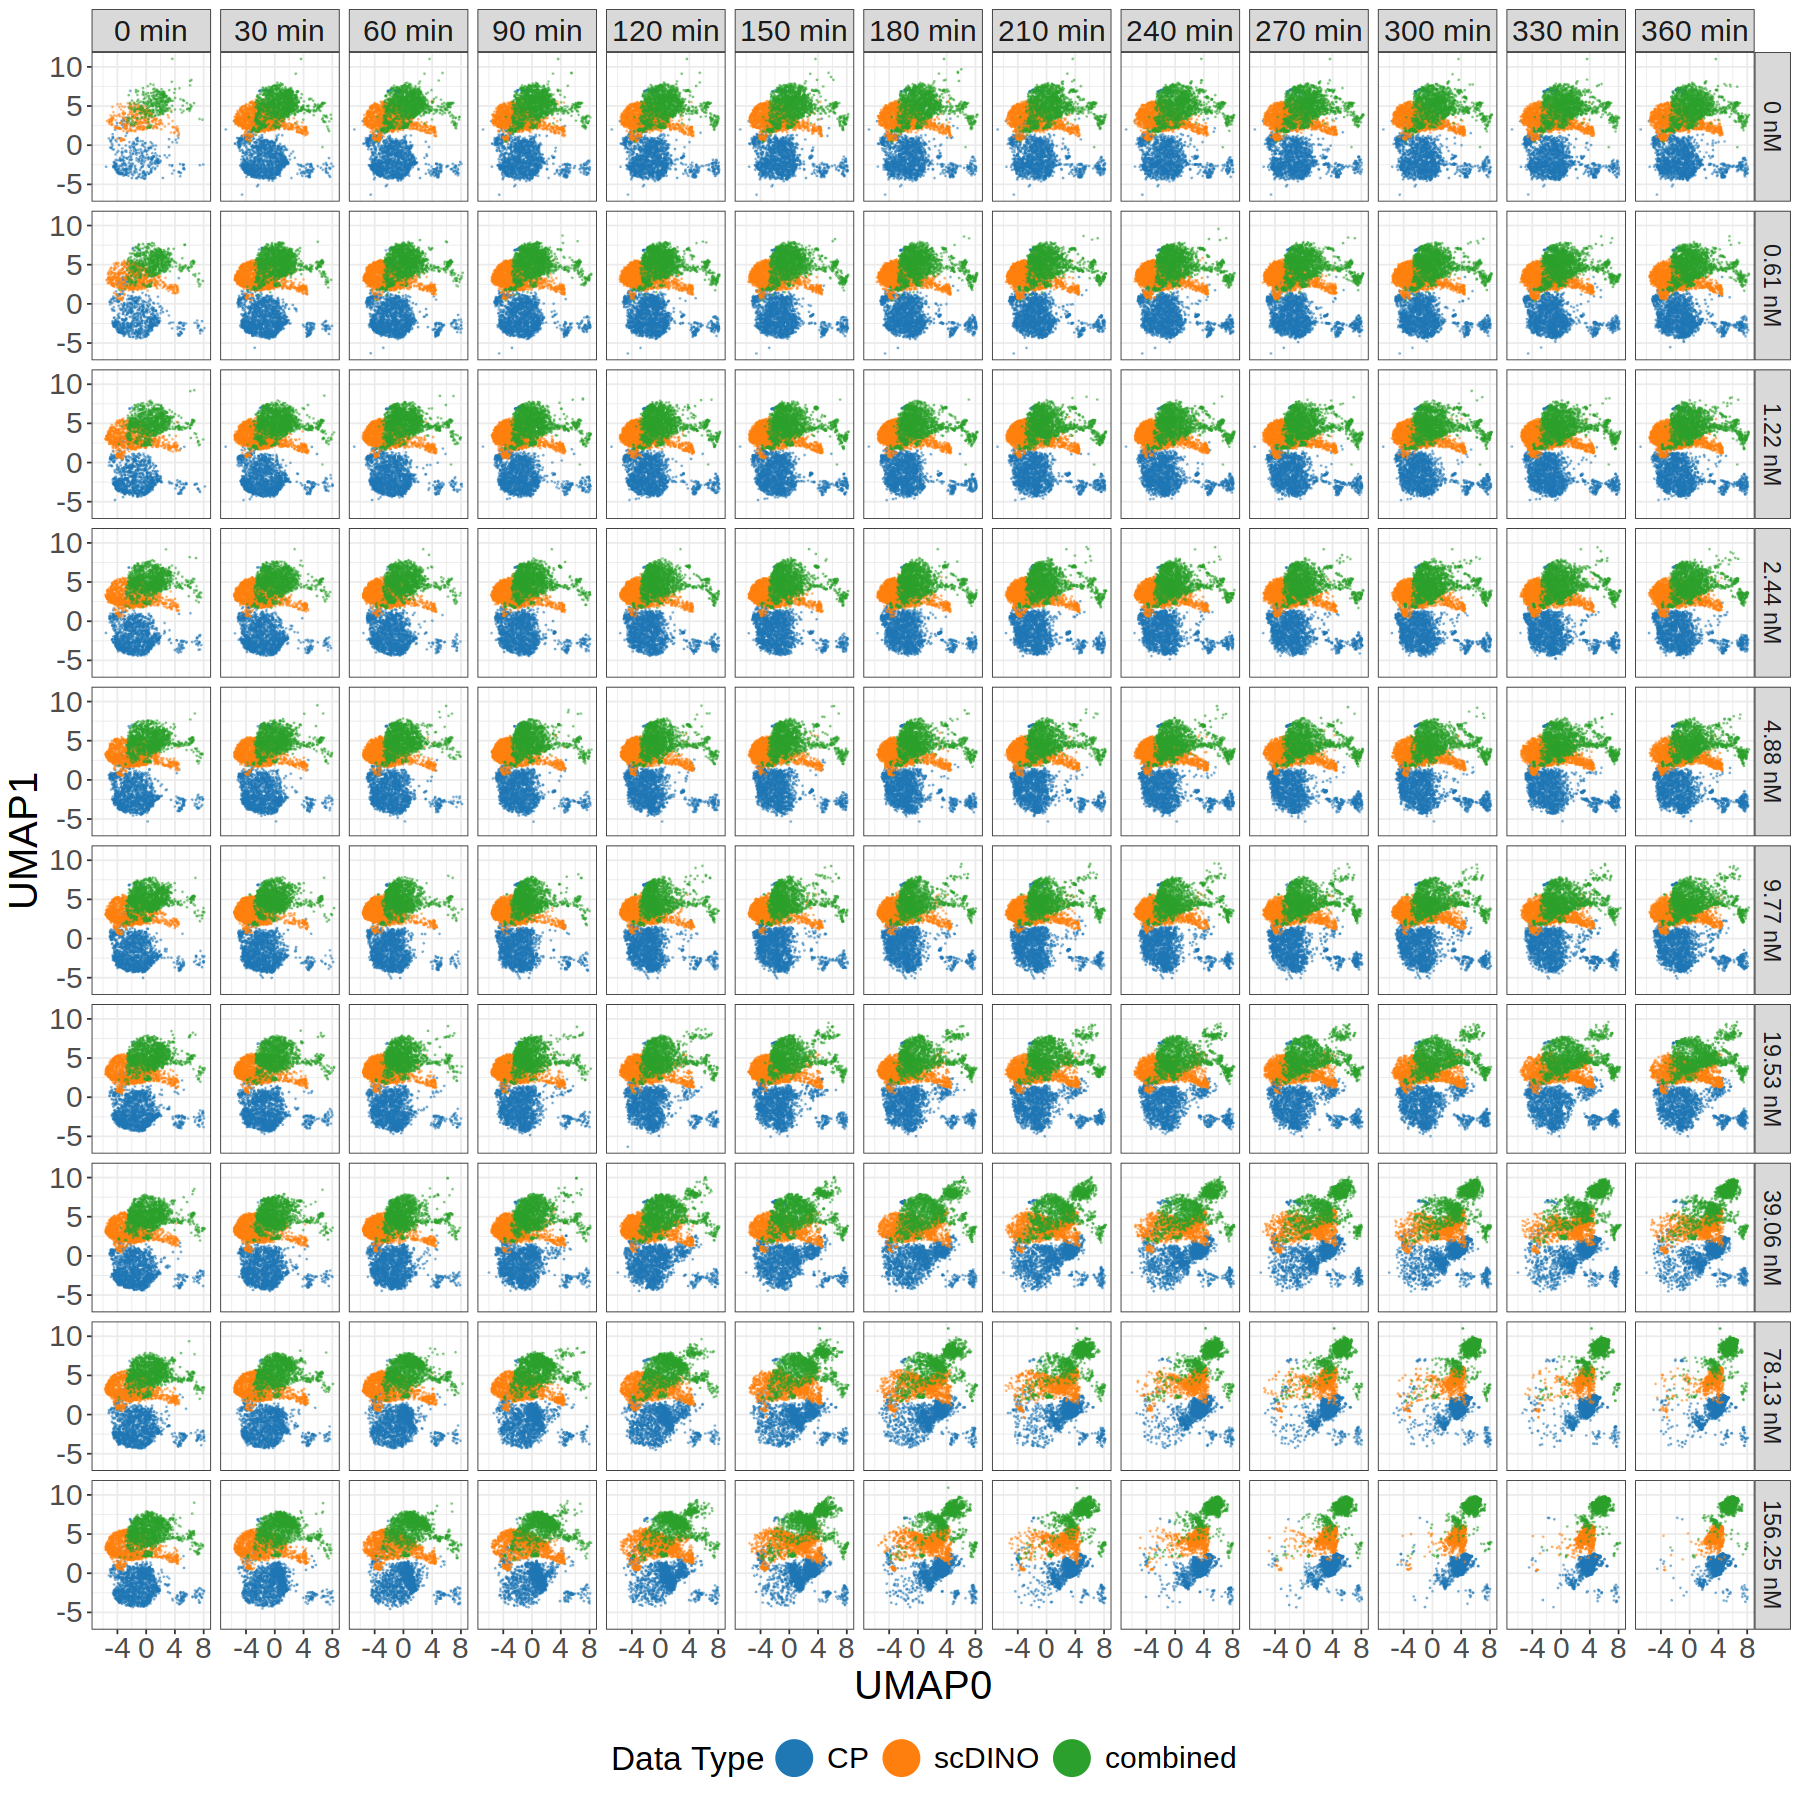

In [7]:
# make a ggplot of the umap
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
umap_plot <- (
    ggplot(data = umap_df, aes(x = UMAP0, y = UMAP1, color = data_type))
    + geom_point(size = 0.2, alpha = 0.4)
    + theme_bw()
    + facet_grid(Metadata_dose~Metadata_Time)
    + scale_color_manual(values = data_type_colors)
    
    + labs( x = "UMAP0", y = "UMAP1")
    + guides(
        color = guide_legend(
            title = "Data Type", 
            title.position = "left",
            override.aes = list(size=10, alpha=1),
            title.theme = element_text(size=20),
            label.theme = element_text(size=18),
            # make horizontal
            nrow = 1,
            byrow = TRUE
            )
        )
    + theme(
        legend.position = "bottom", 
        strip.text.x = element_text(size = 18),
        strip.text.y = element_text(size = 14),
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.title.x = element_text(size = 24),
        axis.title.y = element_text(size = 24),
        )
)
umap_plot
# save  
ggsave(paste0(figures_path,"/umap_plot_time_all_umap_spaces.png"), plot = umap_plot, width = width, height = height, dpi = 600)